In [1]:
from fastbook import *
from fastai.vision.all import *
from nnAudio import features
from scipy.io import wavfile

Getting labels from label phase

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
path = Path('../dataset/DeepShip')
classes = [f for f in os.listdir(path) if os.path.isdir(Path(path/f))]
fns = get_files(path,'.wav')

def path_to_id(p : Path):
    cls  = pathlib.PurePath(p).parent.parent.name
    id = pathlib.PurePath(p).parent.name
    idx = id.rfind('-')
    if idx == -1: return (cls,-1)
    return (cls,id[idx+1:])

## Get data from audio file

In [6]:
sr, audio = wavfile.read(fns[123]) # Loading your audio
(sr,audio.shape)

(32000, (15328000,))

Figure out if the samplingsrate is used for all files in dataset

In [7]:
srs = {}
for f in fns:
    sr, _ = wavfile.read(f)
    srs[sr] = srs.setdefault(sr,0) + 1
srs    

{32000: 621}

the samplingsrate is the same, great!, no we can start focusing on the spectograms

In [6]:
waves = torch.tensor(audio).float() # casting the array into a PyTorch Tensor

In [7]:
waves.shape

torch.Size([15328000])

Plotting the data gives us an impression if reasding works

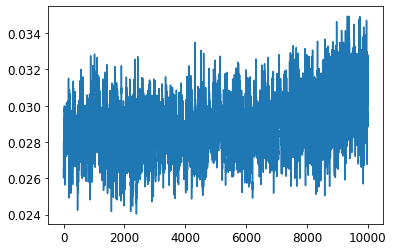

In [8]:
plt.plot(range(10000), waves[10000:20000])

As we can see, the data is no nomalized, the mean is above zero.

## Normalizing

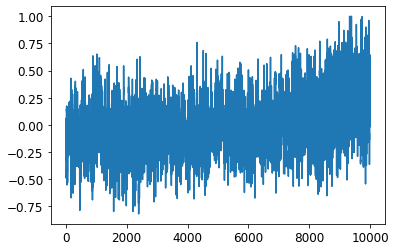

In [9]:
test = waves[10000:20000]
test = test - torch.mean(test)
test = test / max(test)
plt.plot(range(10000), test)

In [15]:
def normSamp(audio):
    ret = audio - torch.mean(audio)
    return ret / torch.max(ret)

def normSpec(spec):
    # take the logarithm of the values
    ret = torch.log10(spec)
    mean = torch.mean(ret)
    std = torch.std(ret)
    # Normalize each frame so its max 1, we dont need the extra dimension
    #return (ret / torch.transpose(torch.max(ret,2)[0],0,1))[0]
    #return (ret / torch.max(ret))[0]
    return  ((ret - mean) / (std*4) + 0.5)[0]

The audio is structuread as a 1d vector, this means we only dealing with a single channel.

In [16]:
samples = normSamp(waves[0:4096*460*3])
img = features.STFT(n_fft=4096, freq_bins=None, hop_length=512,
                              window='hann', freq_scale='linear', center=True, pad_mode='constant',
                               output_format='Magnitude',
                              fmin=10,fmax=100, sr=32000)(samples)

sampling rate = 32000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.1970 seconds


In [17]:
img = normSpec(img)


In [18]:
img.shape

torch.Size([2049, 11041])

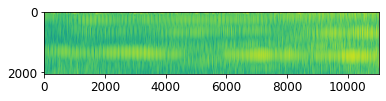

In [19]:
plt.imshow(img)

matplotlib autmattically converts the data into an image. usually we have three layers, one for each color (rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


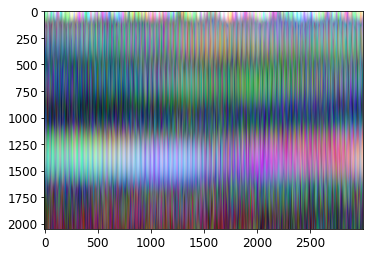

In [18]:
plt.imshow(torch.stack((img[:,0:3000],img[:,3000:6000],img[:,6000:9000]),-1))

there clearly are some data in the frequencies below 1000Hz, indicated by the white lines.

# Getting the spectograms
In order to get as much usefull data to the network, we can make images with different spectograms in each layer.<br>
We can base our calculation on a image size of 460x460. 
Further we can select a random place in each sound clip for each batch, so we get more trainig data.

In speech analisys, frequencies below 50hz is not imortant. Therfor with traditinalo MEL spectorms this informatin is more or less discarded.
This is bad for ship detection

In [21]:
imgsize  = 460

## Low frequency spectogram
A lot of radiated noise from ships comes from eather the propeller or the engine. RPM of a huge tankers propeller is in the range of 70-110rpm. 
this means we have to have a minimum frequency of about 1 Hz. <br>
A "normal" fft size of 4096 is not sufficient.

### Fining out fft size (Nfft)

in order to catch a tone of 1hz the fft size needs to be at least equal to the samplerate.
We find the nearest power of 2, becase fast fourier transfers are efficient at power of 2. 

In [22]:
Nfft = pow(2,int(math.log(sr-1,2))+1)
Nfft

32768

### Finding out how many samples we need (Nskip)

If we have no overlap between each fft, we need 

In [23]:
Nfft * imgsize / sr

471.04

This is to much for some of the training data, and we will loose information between each fft frame.
a better overlap is 80%, this gives us 

In [24]:
Nfft*0.2 * imgsize /sr

94.208

Most of the data is over 94 seconds, this is acceptable

In [25]:
Nskip = int(Nfft*0.2)
rng = int(Nfft*0.2 * imgsize)
(Nskip, rng)

(6553, 3014656)

### Getting the low frequency spectogram
I will use the nnAudio library, and its features.STFT function to calculate the spectogram

In [26]:
# features.STFT?

In [27]:
features.STFT(n_fft=Nfft, hop_length=Nskip, freq_bins=None, 
              window='hann', freq_scale='linear', center=True, pad_mode='constant',
              output_format='Magnitude', fmin=0,fmax=1000, sr=sr)(waves[0:rng])

sampling rate = 32000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 11.8463 seconds


tensor([[[2.4019e+02, 4.0536e+02, 4.7620e+02,  ..., 4.9097e+02, 4.3422e+02, 2.6286e+02],
         [2.4000e+02, 4.0468e+02, 4.7500e+02,  ..., 4.8976e+02, 4.3349e+02, 2.6264e+02],
         [2.3942e+02, 4.0263e+02, 4.7143e+02,  ..., 4.8614e+02, 4.3131e+02, 2.6198e+02],
         ...,
         [2.1883e-01, 4.1053e-01, 6.4921e-01,  ..., 2.3598e-01, 2.0199e-01, 1.9221e-01],
         [2.2825e-01, 4.0148e-01, 6.3921e-01,  ..., 2.1913e-01, 1.9830e-01, 2.0155e-01],
         [2.3725e-01, 3.9007e-01, 6.2729e-01,  ..., 2.0289e-01, 1.9536e-01, 2.1054e-01]]])

This is slow, luckily we can utilize the GPU to our advantage!

In [28]:
stft = features.STFT(n_fft=Nfft, hop_length=Nskip, freq_bins=None, 
              window='hann', freq_scale='linear', center=True, pad_mode='constant',
              output_format='Magnitude', fmin=0,fmax=1000, sr=sr).to('cuda:0')

sampling rate = 32000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 11.9235 seconds


It take some time to compute the kernel, after that its blazing fast

In [29]:
samples = normSamp(waves[:rng].to('cuda:0'))
imgGpu =  normSpec(stft(samples)[:,:imgsize, :imgsize]) 
img = imgGpu.to('cpu')

In [30]:
stft(samples)[:,:,:].shape

torch.Size([1, 16385, 461])

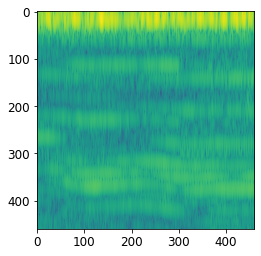

In [31]:
img
plt.imshow(img)

(array([[  0.,   0.,   0., ...,  81., 216., 131.],
        [  0.,   0.,   0., ...,  89., 216., 132.],
        [  0.,   0.,   0., ...,  86., 225., 134.],
        ...,
        [  0.,   1.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   1., ...,   0.,   0.,   0.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.]]),
 array([-0.9101722 , -0.6754154 , -0.44065854, -0.20590171,  0.02885513,  0.26361197,  0.4983688 ,  0.7331256 ,  0.9678825 ,  1.2026393 ,  1.4373962 ], dtype=float32),
 <a list of 460 BarContainer objects>)

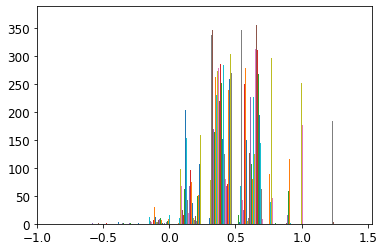

In [32]:
plt.hist(img)

Now we have our first layer! :)

## For the second layer, lets do a higher frequency stft
if we want to catch short transients, we need to reduce the fft length. 
You can eighter have good frequency resolution, or you can have good time resolution, never both.<br>
On higher frequencies we dont need that good a time resolution, we can try 2048

In [33]:
Nffth = 4096
Nskiph = int(Nffth*0.2)
rngh = int(Nffth*0.2 * imgsize)
(Nskiph, rngh)


(819, 376832)

In [34]:
stfth = features.STFT(n_fft=Nffth, hop_length=Nskiph, freq_bins=None, 
              window='hann', freq_scale='linear', center=True, pad_mode='constant',
              output_format='Magnitude', fmin=0,fmax=16000, sr=sr).to('cuda:0')

sampling rate = 32000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.1895 seconds


this gives us a frequency resolution of sr / 2 / (Nffth /2)

In [35]:
sr / 2 / (Nffth/2)

7.8125

In [36]:
460 / 15

30.666666666666668

we can have a little overlap

In [32]:
460*15

6900

In [33]:
img = normSpec(stfth(normSamp(waves[:rngh].to('cuda:0')))).to('cpu')
img.shape

torch.Size([2049, 461])

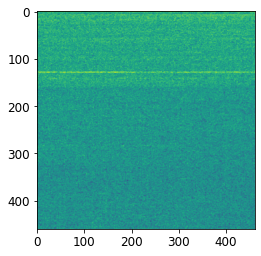

In [34]:
plt.imshow(img[1:461,:])

(array([[  0.,   0.,   0., ...,  77., 215., 152.],
        [  0.,   0.,   0., ..., 236.,   1.,   0.],
        [  0.,   0.,   0., ..., 143.,   0.,   0.],
        ...,
        [  0.,   1.,   2., ...,   0.,   0.,   0.],
        [  0.,   1.,   4., ...,   0.,   0.,   0.],
        [  0.,   0.,   2., ...,   0.,   0.,   0.]]),
 array([-0.39237168, -0.26213083, -0.13188998, -0.00164914,  0.12859172,  0.25883257,  0.3890734 ,  0.5193142 ,  0.6495551 ,  0.77979594,  0.9100368 ], dtype=float32),
 <a list of 460 BarContainer objects>)

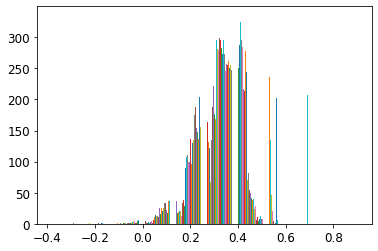

In [ ]:
plt.hist(img[1:461,:])

## CQT scores great, lets do that for one of the input layers

In [ ]:
#features.CQT1992v2?

In [53]:
cqttf = features.CQT(sr=sr,bins_per_octave=60, n_bins=imgsize+2).to('cuda:0')

CQT kernels created, time used = 0.4584 seconds


In [57]:
rngc = 235200 #trial and error

samples = normSamp(waves[0:rngc].to('cuda:0'))
img = cqttf(samples)[0]
img = (img /  torch.max(img)) .to('cpu')

In [58]:
img.shape

torch.Size([462, 460])

In [10]:
int(sr*7.35)

235200

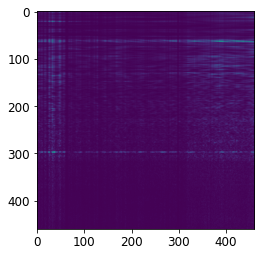

In [42]:
plt.imshow(img )

I have not read up on CQT, but i found something that gives me a  image with the right size :)

In [12]:
def normCqt(cqt):
    ret = torch.log10(cqt) / 2
    #return (ret / torch.max(ret,1)[0])[0]
    return (ret - torch.mean(ret) + 0.5)[0]

In [37]:
samples = normSamp(waves[0:235200].to('cuda:0'))
img = normCqt(cqttf(samples)).to('cpu')

plt.imshow(img)

NameError: name 'normCqt' is not defined

In [38]:
torch.std(img)

tensor(0.2500)

(array([[  0.,   0.,   0., ...,  81., 216., 131.],
        [  0.,   0.,   0., ...,  89., 216., 132.],
        [  0.,   0.,   0., ...,  86., 225., 134.],
        ...,
        [  0.,   1.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   1., ...,   0.,   0.,   0.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.]]),
 array([-0.9101722 , -0.6754154 , -0.44065854, -0.20590171,  0.02885513,  0.26361197,  0.4983688 ,  0.7331256 ,  0.9678825 ,  1.2026393 ,  1.4373962 ], dtype=float32),
 <a list of 460 BarContainer objects>)

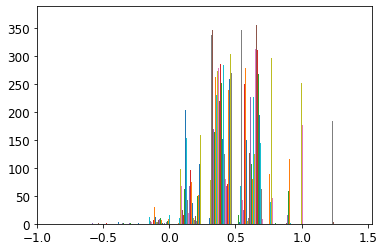

In [39]:
plt.hist(img)

# Convert it all to fastai compatible functions

In [40]:
(rng, rngh, rngc)

NameError: name 'rngc' is not defined

In [41]:
sampsLow = normSamp(waves[:rng].to('cuda:0'))
sampsHigh = normSamp(waves[:rngh].to('cuda:0'))
sampsCqt = normSamp(waves[:rngc].to('cuda:0'))


lf = normSpec(stft(sampsLow))[0:imgsize, 0:imgsize].to('cpu')
hf = normSpec(stfth(sampsHigh))[0:imgsize, 0:imgsize].to('cpu')
cqt = normCqt(cqttf(sampsCqt))[0:imgsize, 0:imgsize].to('cpu')

(lf.shape, hf.shape, cqt.shape)

NameError: name 'rngc' is not defined

In [42]:
img = torch.stack((lf,hf,cqt),0)
img.shape

NameError: name 'lf' is not defined

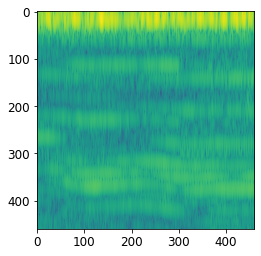

In [43]:
plt.imshow(img)

We can normalize the image with pytorch

In [44]:
norm = Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

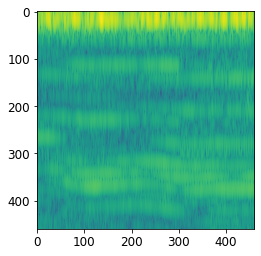

In [45]:
img = norm(img)
plt.imshow(img)

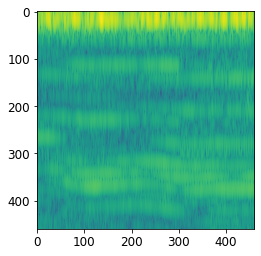

In [46]:
plt.imshow(img)